# Minimizing a function

To determine the best spatial parameters to set the rate of a poisson process, we need to use a method to minimize a function.

[scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) could probably be used for this.

Below are two simple examples of how it works. 

### Minimise one variable

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import poisson, norm
from scipy.special import factorial

Here is a function for which we want to find the minimum.


In [127]:
fun = lambda x : x**2 -12*x + 20

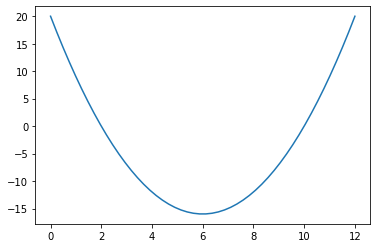

In [128]:
plt.plot(np.linspace(0,12),fun(np.linspace(0,12)))

In [129]:
results = minimize(fun=fun,x0=0)
print(results)

      fun: -15.9999999999999
 hess_inv: array([[0.49999997]])
      jac: array([-9.53674316e-07])
  message: 'Optimization terminated successfully.'
     nfev: 8
      nit: 3
     njev: 4
   status: 0
  success: True
        x: array([5.99999969])


In [5]:
if results.success:
    print("Success")
    print("min: {}, y =: {}".format(results.x,results.fun))
else:
    print("Could not find a minimum")

Success
min: [5.99999969], y =: -15.9999999999999


## Minimize 2 variables

Here is another example in which we want to optimize 2 parameters. 

We want to fence 3 sides of a rectangular garden (x, x and y). We have 100 meters of fence. What is the choice of x and y that maximize the area of the garden.

In [6]:
def fun(xy):
    x = xy[0]
    y = xy[1]
    area = x*y
    return -area

x0=[50,50]
cons = ({'type':'eq', 'fun': lambda xy : 2*xy[0] + xy[1] - 100}) # our constrain is that 2*x+y=100
bounds = ((1,100),(1,100))
results = minimize(fun=fun,x0=x0, constraints=cons,bounds=bounds)

print(results)
if results.success:
    
    print("Success")
    print("x: {}, y =: {}".format(results.x[0], results.x[1]))
else:
    print("Could not find a minimum")

     fun: -1250.0000000000002
     jac: array([-50., -25.])
 message: 'Optimization terminated successfully'
    nfev: 12
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([25., 50.])
Success
x: 24.999999999999993, y =: 50.00000000000002


## Poisson distribution

We will use the Poisson distribution to generate spike trains of simulated neurons. 

The probability mass function is 

$f(k) = exp(-\mu) \frac{\mu^{k}}{k!} $

In [7]:
def poi(x,mu):
    return np.exp(-mu)*(mu**x/np.math.factorial(x))

In [8]:
poi(0,1.2)

0.30119421191220214

Now with scipy.stats.poisson

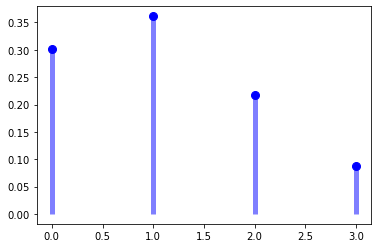

In [9]:
mu=1.2
x = np.arange(poisson.ppf(0.01, mu),
              poisson.ppf(0.99, mu))
plt.plot(x, poisson.pmf(x, mu), 'bo', ms=8, label='poisson pmf')
plt.vlines(x, 0, poisson.pmf(x, mu), colors='b', lw=5, alpha=0.5)

In [10]:
poisson.pmf(0,1.2)

0.30119421191220214

We can simulate a random poisson process with rvs

In [11]:
poisson.rvs(mu=1.2,size=10)

array([3, 2, 3, 0, 2, 2, 2, 1, 1, 1])

With variable rates

In [12]:
poisson.rvs(mu=np.arange(0,10),size=10)

array([ 0,  0,  1,  3,  5,  7,  6,  8, 14, 12])

# Generate the animal path on a linear track

## Simulate a spike train of a place cell on a 1D track

We first need the animal path along the track.

Rec time:60 sec
dt:0.02 sec
samples:3000


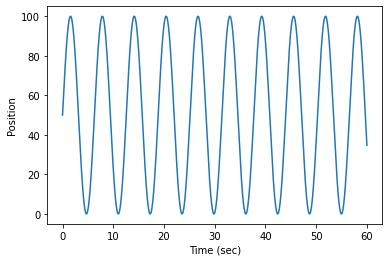

In [13]:
trackLength=100
samplingRate = 50
recordingTimeSec=60
samples=recordingTimeSec*samplingRate
dt = 1/samplingRate

print("Rec time:{} sec".format(recordingTimeSec))
print("dt:{} sec".format(dt))
print("samples:{}".format(samples))
time = np.linspace(0,recordingTimeSec,samples)
position = (np.sin(time)+1)/2*trackLength
plt.plot(time,position)
plt.ylabel("Position")
plt.xlabel("Time (sec)")
plt.show()

## Spatial selectivity

We need to have a firing rate that depends on the position of the animal. We can model this with a Gaussian distribution.

The mean and standard deviation will determine where the field is and how broad it is. 

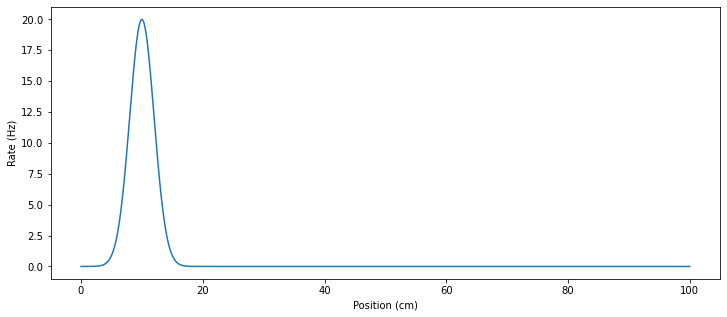

In [57]:
xx = np.linspace(0,trackLength,1000) # position
loc=10
scale=2
peakRateHz=20

rate = norm.pdf(xx,loc=loc,scale=scale)
maxDist=rate.max()
rate = rate/maxDist*peakRateHz
plt.figure(figsize=(12,5))
plt.plot(xx, rate)
plt.ylabel("Rate (Hz)")
plt.xlabel("Position (cm)")
plt.show()

We can write a function to calculate the rate a a given position on the track.

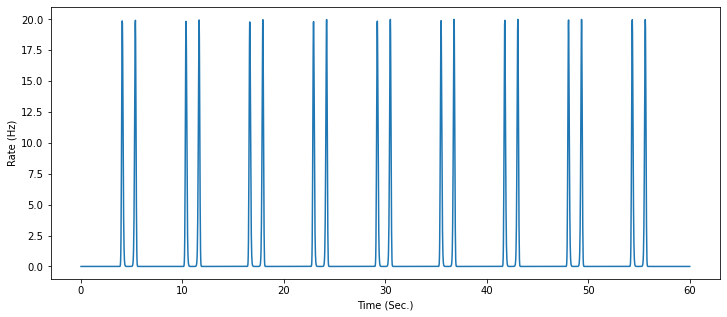

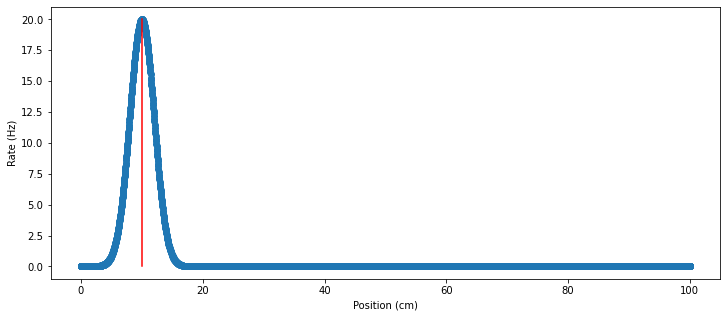

In [58]:
def rateAtPosition(position,loc=loc,scale=scale,peakRateHz=peakRateHz):
    maxDist=norm.pdf(loc,loc=loc,scale=scale)
    return norm.pdf(position,loc=loc,scale=scale)/maxDist*peakRateHz
plt.figure(figsize=(12,5))
plt.plot(time,rateAtPosition(position))
plt.ylabel("Rate (Hz)")
plt.xlabel("Time (Sec.)")
plt.show()
plt.figure(figsize=(12,5))
plt.scatter(position,rateAtPosition(position))
plt.ylabel("Rate (Hz)")
plt.xlabel("Position (cm)")
plt.plot([loc,loc],[0,peakRateHz],c="red")
plt.show()

## Simulate a spike train

To model the neuron, we need a spike train with which we will adjust our model parameters. 

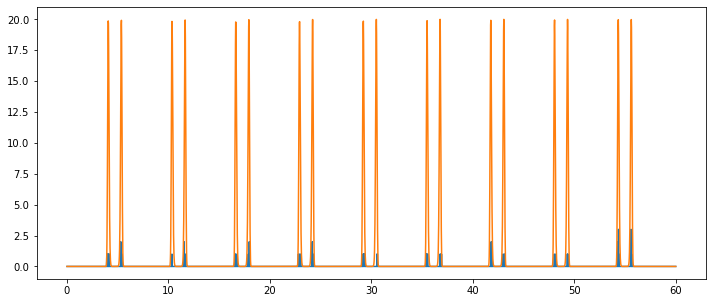

In [43]:
rate = rateAtPosition(position)
spikes = poisson.rvs(mu=rate*dt) # sample from a Poisson distribution. We pass the rate array to the function.
plt.figure(figsize=(12,5))
plt.plot(time,spikes)
plt.plot(time,rateAtPosition(position))

Most spikes occur when the firing rate is high. This seems to be working.

## Create a linear firing rate map for the simulated neuron

Occupancy map

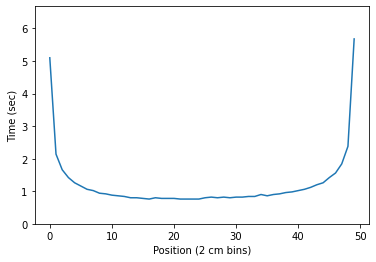

In [110]:
cmPerBin=2
nBins=trackLength/cmPerBin
bins = np.arange(0,trackLength+cmPerBin,cmPerBin)
occ,edges = np.histogram(position,bins= bins)
occ = occ*dt
plt.plot(occ)
plt.xlabel("Position ({} cm bins)".format(cmPerBin))
plt.ylabel("Time (sec)")
plt.ylim(0,np.max(occ)+1)
plt.show()

We need to bin the position of the spikes in the same bins as the occupancy map

In [111]:
spikeCounts=np.zeros_like(occ)
binIndices = (position/cmPerBin).astype(int)
for i,count in enumerate(spikes): # ugly for loop
    spikeCounts[binIndices[i]]+= count

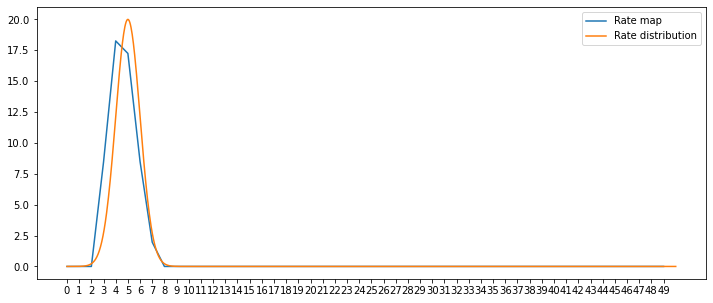

In [125]:
rateMap = spikeCounts/occ # create a firing rate map

plt.figure(figsize=(12,5))
plt.plot(rateMap, label="Rate map")
#plt.plot((xx/cmPerBin).astype(int), rate, label="Binned Rate distribution")
plt.plot(xx/cmPerBin, rate, label="Rate distribution")
plt.xticks(np.arange(0,nBins,1))
plt.legend()
plt.show()

* The firing rate map is shifted to the left because values from 0-1 are set at 0, values from 1-2 are set at 1, etc. 
* The rate is approximately peak/2 because the bin contains the peak and the values before and after it. 

**I don't know why the Rate map is not symetrical**



# Model this neuron

We will model this neuron using the position data. 

$r = exp(X^{t}w)/dt$


## Create a behavioral state matrix $X^{T}$

This is a bin x time matrix filled with 0 and 1 at the position of the animal.


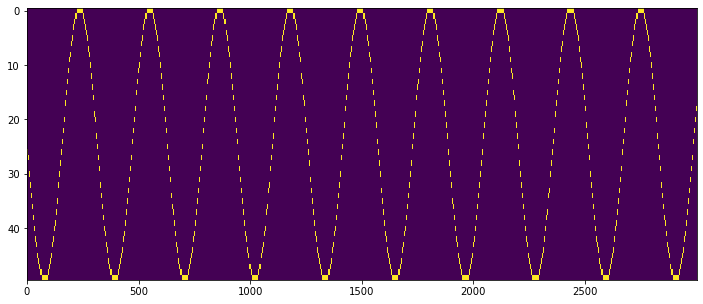

In [113]:
binIndices = (position/cmPerBin).astype(int)
Xt = np.zeros((int(trackLength/cmPerBin),position.shape[0]))
# pretty ugly and slow code I believe
for i in range(position.shape[0]):
    Xt[binIndices[i],i]=+1
plt.figure(figsize=(12,5))
plt.imshow(Xt,aspect="auto",interpolation="None")

## Create the learned parameter array $w$

We will set their value to one as a starting point.

$X^{t}$ has only one value that is not 0 per column. The value that is not 0 is 1. So it means that at every time windown, one parameter of $w$ goes into the exponential function to determine the rate. 

To get an idea of what values our learned parameters should be, we can simply plot the exponential function.

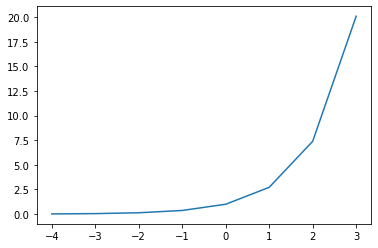

In [114]:
x = np.arange(-4,4)
plt.plot(x,np.exp(x))
plt.show()

So a firing rate of 20.0 Hz, would require a single value of $w$ to be 3. We will need to muliply the rate by $dt$ to adjust the rate to the window size.

We can initialize our values of w to values in the expected range.


In [115]:
w = np.random.uniform(-2,4,Xt.shape[0])
print(w)

[-0.54422441  2.90055862  2.15070783 -1.47752939  2.26494774  1.27322901
  1.05111958  1.82605498  3.27205607 -0.84648131  2.92461054  1.41348906
 -0.25766318  1.8075154   1.77074543 -0.13589804  1.91600638 -0.27835491
  3.99873141  2.61538994  1.83285288  0.71564895  0.51092268  0.62539152
 -1.73371425  3.48443758  2.95364877  0.98940462  3.266548   -0.85408695
  0.32735537  1.46210006  0.99507354  1.27101812 -0.40152403  3.08498041
  1.82446584  2.12761052  1.12369932  0.18536916  1.44079761 -0.09501583
 -0.52613826 -0.33274459  0.39936364  1.60514717 -1.49119574  3.41203346
 -0.95349056  3.79242146]


## Calculate the firing rate in time using $Xt$ and $w$

$r = exp(X^{t}w)*dt$

We can get the dot product of the vector w and the matrix Xt.


Since we apply an exponential function, it is a good idea to look how such function looks like.

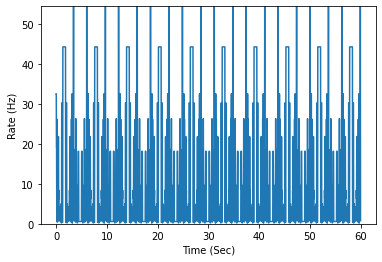

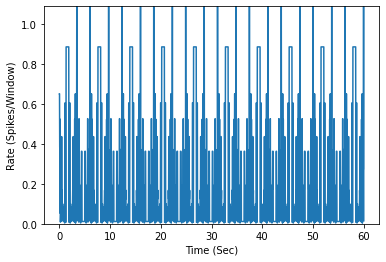

In [116]:
r = np.exp(np.expand_dims(w,0)@Xt)
plt.plot(time,r[0,:])
plt.ylim(0,r.max())
plt.ylabel("Rate (Hz)")
plt.xlabel("Time (Sec)")
plt.show()

r = np.exp(np.expand_dims(w,0)@Xt)*dt # this time taking into account the window size
plt.plot(time,r[0,:])
plt.ylim(0,r.max())
plt.ylabel("Rate (Spikes/Window)")
plt.xlabel("Time (Sec)")
plt.show()

# Optimization of the learned parameters

We need to maximize the log-likelihood of the real spike train $n$ given the model's estimated rate vector r. 

This is the log-likelihood function for a Poisson process with variable mean. Have a look [here](https://www.statology.org/mle-poisson-distribution/) to understand how we got here.

$l = \sum_{t} n_{t} log(r_{t}) - r_{t} - log(n_{t}!)$





In [1]:
l = np.sum(spikes * np.log(r) - r - np.log(factorial(spikes)))
print("Log-likelihood of real spikes given the model estimated firing rate: ",l)

NameError: name 'np' is not defined

## Smoothing by penalizing large differences between adjacent parameters

To get smooth "parameter maps" from the model, there is usually a penalty for having large differences between adjacent bins in the map. 

$\beta (\sum_{j} \frac{1}{2} (w_{j} - w_{j+1})^2 )$

$\beta$ is a constant set to 20. 

$j$ is iterating over the parameters in the vector w.

This formula will always give a positive number. The higher the number, the larger the differences are between adjacent values.

In [118]:
beta=1
beta * np.sum(0.5 * np.diff(w)**2)

140.2953447929356

## Minimine the objective function

We can now find the parameters $w$ that will maximize the log-likelihood function and smoothing penality

In [130]:
def objective_function(w,spikes,Xt,beta):
    """
    Function for which we want to find the minimum
    
    We estimate the rate using our model.
    Than calculate the log likelihood of our spike train given our model.
    We calculate the smoothing penalty
    
    Returns 
    The negative log likelihood because our optimizer will look for the minimum
    """
    r = np.exp(np.expand_dims(w,0)@Xt) # estimated rate
    l = np.sum(spikes * np.log(r) - r - np.log(factorial(spikes))) # log likelihood, high is more likely
    sm = beta * np.sum(0.5 * np.diff(w)**2) # smoothing penalty, 0 is very smooth,  large values are not smooth
    
    return -l+sm

x0=w
results = minimize(fun=objective_function,x0=x0,args=(spikes,Xt,beta))
print(results.message)
w_opt = results.x

Optimization terminated successfully.


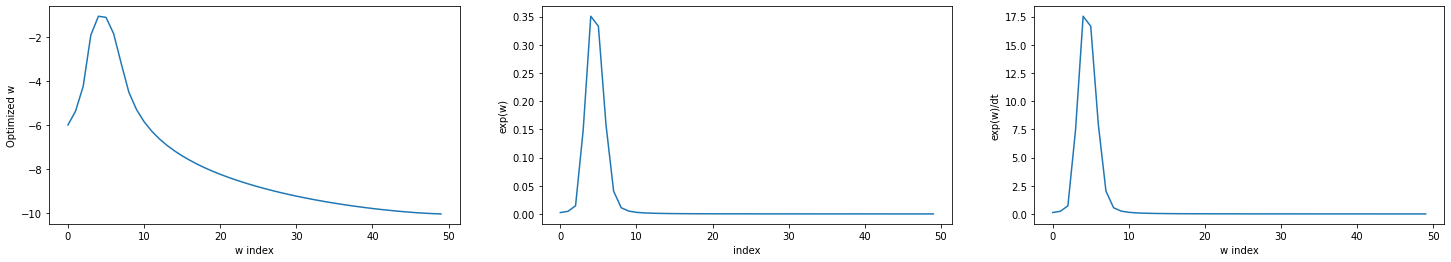

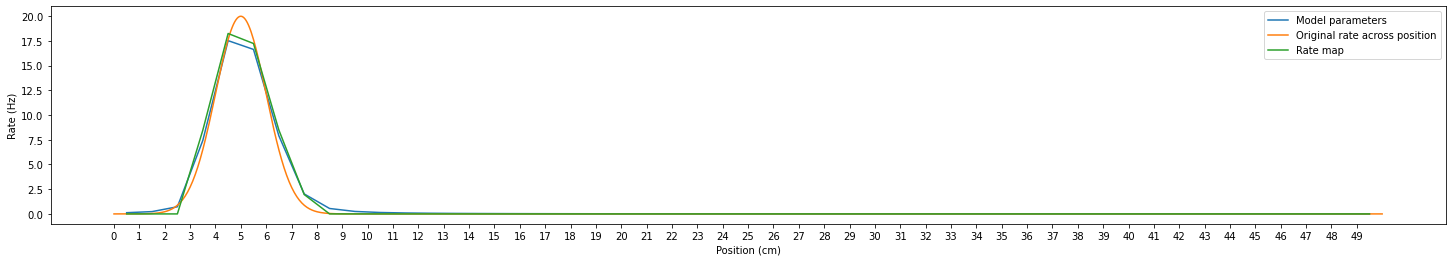

In [131]:

fig,ax = plt.subplots(1,3,figsize=(25,4))
ax[0].plot(w_opt)
ax[0].set_xlabel("w index")
ax[0].set_ylabel("Optimized w")

ax[1].plot(np.exp(w_opt))
ax[1].set_xlabel("index")
ax[1].set_ylabel("exp(w)")

ax[2].plot(np.exp(w_opt)/dt)
ax[2].set_xlabel("w index")
ax[2].set_ylabel("exp(w)/dt")

plt.show()


fig,ax = plt.subplots(1,1,figsize=(25,4))
ax.plot(np.arange(0,nBins)+0.5,np.exp(w_opt)/dt,label="Model parameters")
ax.plot(xx/cmPerBin, rateAtPosition(xx),label="Original rate across position")
ax.plot(np.arange(0,nBins)+0.5,rateMap, label="Rate map")

ax.set_ylabel("Rate (Hz)")
ax.set_xlabel("Position (cm)")
ax.set_xticks(np.arange(0,nBins,1))
ax.legend()

plt.show()

So the model managed to get a tuning curve that is similar to the original one.

**We will need to understand why binning the gaussian distribution does not results in symetrical rate maps.**

## Compare the predicted rate in time vs the real rate in time

We can calculate the model rate in time using the learned parameters.

In [123]:
r = np.exp(np.expand_dims(w_opt,0)@Xt) # estimated rate
r = r.flatten()

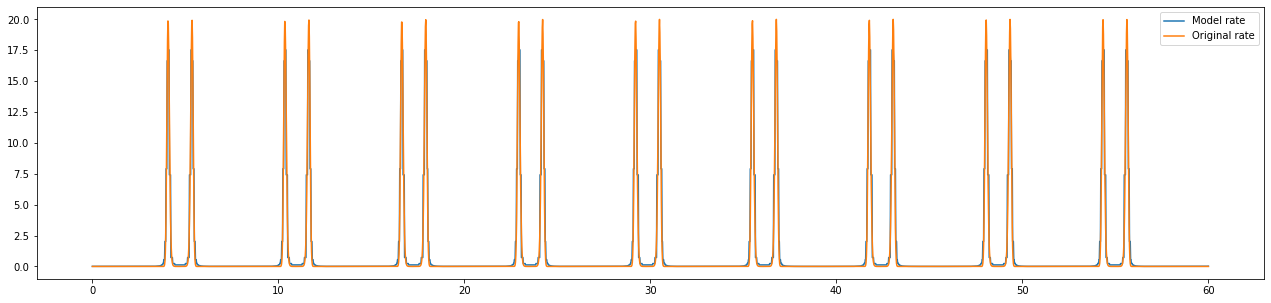

In [124]:
plt.figure(figsize=(22,5))
plt.plot(time,r/dt, label="Model rate")
plt.plot(time,rateAtPosition(position),label="Original rate")
plt.legend()
plt.show()